# Iteration 0: Cell to cell type assignment. Cell label = 3990

In [ ]:
# Uncomment the line below to show all rows in a pandas dataframe
# import pandas as pd
# pd.set_option('display.max_rows', None)

### This is a notebook demonstrating what happens under the hood in the cell to cell type step in pciSeq

The focus here is on a particular cell (with label 3990) that has 32 gene counts but inside the first iteration the most likely class is the Zero class

![Screenshot_3990.png](Screenshot_3990.png)
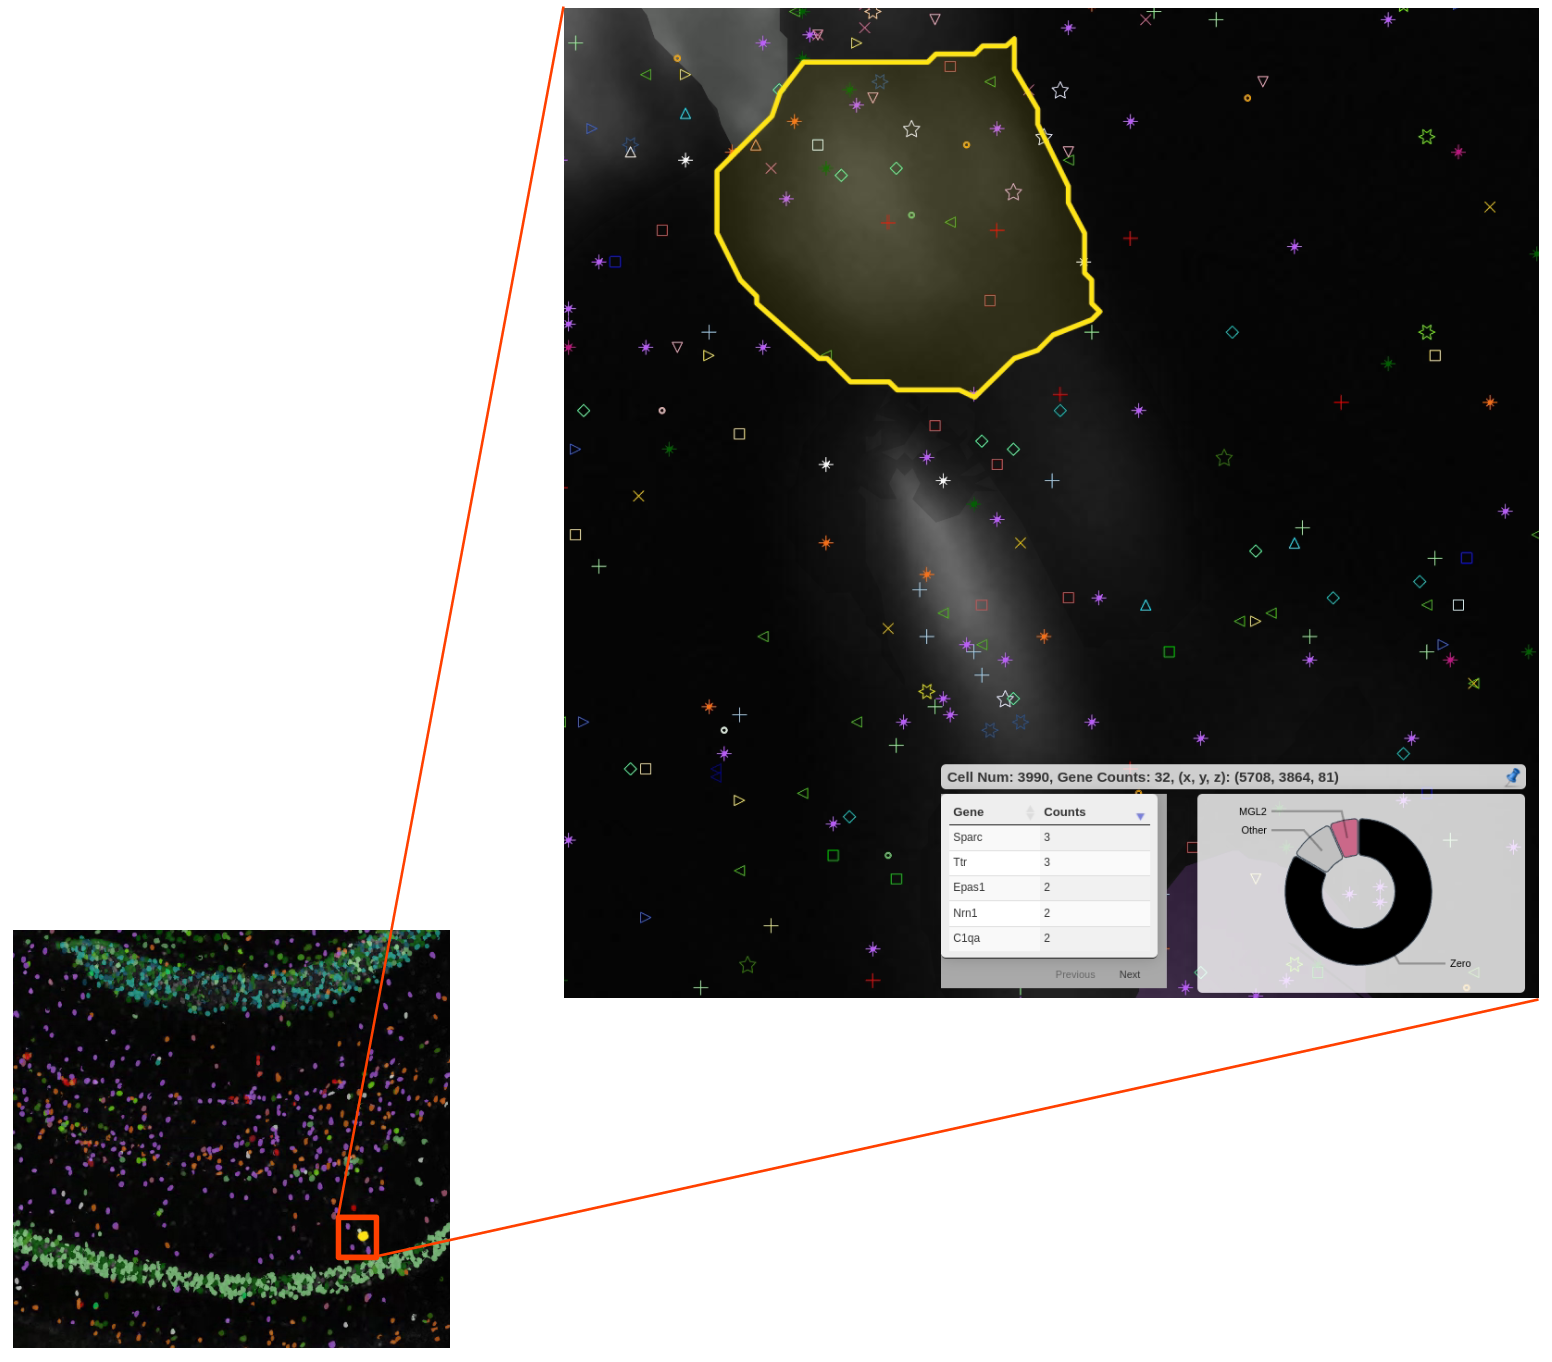

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy.special import softmax
import gdown

In [3]:
!pip install git+https://github.com/acycliq/pciSeq.git@dev_3d
import pciSeq

  Cloning https://github.com/acycliq/pciSeq.git (to revision dev_3d) to /tmp/pip-req-build-nitrv1nu
  Running command git clone --filter=blob:none --quiet https://github.com/acycliq/pciSeq.git /tmp/pip-req-build-nitrv1nu
  Running command git checkout -b dev_3d --track origin/dev_3d
  Switched to a new branch 'dev_3d'
  Branch 'dev_3d' set up to track remote branch 'dev_3d' from 'origin'.
  Resolved https://github.com/acycliq/pciSeq.git to commit 31fd7688f1f848d9e59931636ce39479614ea23d
  Preparing metadata (setup.py) ... done


In [8]:
file_id = "1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = "pciSeq.pickle"

In [9]:
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M
From (redirected): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M&confirm=t&uuid=65723672-0687-4031-ae5b-b7a6fe8a79f3
To: /tmp/pciSeq/data/pciSeq.pickle
100%|██████████████████████████████████████| 1.79G/1.79G [03:21<00:00, 8.87MB/s]


'pciSeq.pickle'

In [10]:
obj = pd.read_pickle(output)

In [4]:
my_cell = 3990

In [5]:
# Set the hyperparameters
rSpot = 2.0               # Spread of the negative binomial
SpotReg = 0.1             # Spot regularization: Additive factor applied to the single cell data
inefficiency = 0.2        # multiplicative factor applied to the single cell data

In [11]:
# Another piece of information comes from the single cell data. For simplicity
# we are pulling here only the gene expressions for 'TEGLU23' (expected in CA3) 
# and 'TEGLU24', 'TEGLU21' (expected in CA3) 
my_class_definitions = obj.single_cell.mean_expression[
['MGL2', 'MGL1', 'VLMC1', 'PER3', 'VECC', 'TEGLU6', 'Zero']
]
my_class_definitions

class_name,MGL2,MGL1,VLMC1,PER3,VECC,TEGLU6,Zero
gene_name,,,,,,,
Abi3bp,0.002747,0.004405,0.001425,0.003356,0.000976,0.090301,0.0
Acly,0.095604,0.056388,0.041311,0.036913,0.123902,0.096990,0.0
Adcyap1,0.000549,0.000881,0.002849,0.000000,0.000000,0.053512,0.0
Adora2a,0.004396,0.004405,0.168091,0.318792,0.316098,0.000000,0.0
Afp,0.028571,0.027753,0.000000,0.000000,0.000000,0.006689,0.0
...,...,...,...,...,...,...,...
Vtn,0.002747,0.015859,3.950143,14.093961,0.038049,0.001672,0.0
Wfs1,0.007692,0.005727,0.012821,0.020134,0.026341,0.053512,0.0
Yjefn3,0.005495,0.003084,0.004274,0.010067,0.006829,0.060201,0.0


### Part 1. Initialization

In [12]:
# To set the initial gene counts for any given cell we collect the gene reads inside the cell boundaries
# For cell 10275 these gene reads are the spots below
spots_3990 = obj.spots.data[obj.spots.data.label == my_cell]
spots_3990

,x,y,z,plane_id,label,gene_name,score
spot_id,,,,,,,
75255,5699.880859,3852.592529,94.290878,29,3990,Apoe,0.3460
80074,5711.880859,3847.592529,110.362312,34,3990,Bsg,0.9688
80682,5721.880859,3850.592529,62.148018,19,3990,C1qa,0.3120
80683,5688.880859,3860.592529,71.790878,22,3990,C1qa,0.3700
82055,5695.880859,3860.592529,68.576591,21,3990,Calb1,0.5537
83291,5706.880859,3866.592529,65.362305,20,3990,Cck,0.5737
83660,5702.880859,3849.592529,100.719444,31,3990,Ccn2,0.7220
95981,5719.880859,3863.592529,62.148018,19,3990,Ctsd,0.3990
97828,5701.880859,3851.592529,94.290878,29,3990,Cx3cr1,0.4080


In [16]:
# Hence we aggregate per gene and we derive the gene counts
cgc = spots_3990.groupby('gene_name').size()
cgc

gene_name
Apoe       1
Bsg        1
C1qa       2
Calb1      1
Cck        1
Ccn2       1
Ctsd       1
Cx3cr1     1
Enc1       1
Epas1      2
Fam107a    1
Fos        1
Gabrd      1
Gnb3       1
Gng12      1
Itgam      1
Lamp5      1
Ndnf       1
Nrn1       2
Pglyrp1    1
Pltp       1
Sparc      3
Stmn1      1
Trf        1
Ttr        3
dtype: int64

In [15]:
# the cell has 32 reads inside its boundaries
cgc.sum()

32

In [17]:
# The cell gene counts introduced above contain only genes with gene reads > 0.
# We need however the full gene panel
cgc = cgc.reindex(obj.genes.gene_panel, fill_value=0)

In [18]:
# Note also that the eta (the random variable to model the gene inefficiency) is initialied as a vector of ones with lenght
# equal to the number of genes:
eta_bar = np.ones(obj.nG)

### Part 2. Cell to cell type

In [19]:
def negative_binomial_loglikelihood(x: np.ndarray, r: float, p: np.ndarray) -> np.ndarray:
    log_likelihood = x * np.log(p) + r * np.log(1 - p)

    return log_likelihood

In [20]:
# prepare now the data from the negative binomial
ScaledExp = my_class_definitions * inefficiency * eta_bar[:, None]
ScaledExp = ScaledExp + SpotReg
p = ScaledExp / (ScaledExp + rSpot)

In [21]:
# evaluate the loglikelihood
class_contr = negative_binomial_loglikelihood(cgc.values[:, None], rSpot, p.values)
class_contr.sum(axis=0)

array([-126.49989569, -127.7241957 , -127.78324752, -128.20362474,
       -128.40587062, -128.60335377, -128.06494111])

In [23]:
# some housekeeping, results look better in a dataframe
class_contr_df = pd.DataFrame(class_contr, columns=['MGL2', 'MGL1', 'VLMC1', 'PER3', 'VECC', 'TEGLU6', 'Zero']).set_index(obj.genes.gene_panel)
class_contr_df

,MGL2,MGL1,VLMC1,PER3,VECC,TEGLU6,Zero
Abi3bp,-0.098104,-0.098419,-0.097852,-0.098219,-0.097766,-0.114707,-0.09758
Acly,-0.115708,-0.108292,-0.105434,-0.104599,-0.121043,-0.115970,-0.09758
Adcyap1,-0.097685,-0.097748,-0.098123,-0.097580,-0.097580,-0.107747,-0.09758
Adora2a,-0.098417,-0.098419,-0.129344,-0.157399,-0.156901,-0.097580,-0.09758
Afp,-0.103015,-0.102860,-0.097580,-0.097580,-0.097580,-0.098854,-0.09758
...,...,...,...,...,...,...,...
Vtn,-0.098104,-0.100599,-0.736238,-1.799832,-0.104815,-0.097899,-0.09758
Wfs1,-0.099045,-0.098671,-0.100021,-0.101412,-0.102591,-0.107747,-0.09758
Yjefn3,-0.098627,-0.098168,-0.098394,-0.099497,-0.098881,-0.109014,-0.09758
Zcchc12,-0.098940,-0.098335,-0.098937,-0.098219,-0.098324,-0.100763,-0.09758


In [28]:
# Get the total loglikelihood
class_contr_df.sum(axis=0).sort_values(ascending=False)

MGL2     -126.499896
MGL1     -127.724196
VLMC1    -127.783248
Zero     -128.064941
PER3     -128.203625
VECC     -128.405871
TEGLU6   -128.603354
dtype: float64

I seems that the MGL2 class has the highest loglikelihood. However the cell was given the Zero type as the most likely one. 

Lets look at the prior then.

In [25]:
log_prior = pd.DataFrame(obj.cellTypes.log_prior).set_index(obj.cells.class_names)
log_prior = log_prior.loc[['MGL2', 'MGL1', 'VLMC1', 'PER3', 'VECC', 'TEGLU6', 'Zero']]
log_prior

,0
MGL2,-4.804021
MGL1,-4.804021
VLMC1,-4.804021
PER3,-4.804021
VECC,-4.804021
TEGLU6,-4.804021
Zero,-0.693147


In [29]:
class_total_df = class_contr_df.sum(axis=0) + log_prior.squeeze()
class_total_df.sort_values(ascending=False)

Zero     -128.758088
MGL2     -131.303917
MGL1     -132.528217
VLMC1    -132.587268
PER3     -133.007646
VECC     -133.209891
TEGLU6   -133.407375
dtype: float64